<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%204/Assignment/Imdb_Dataset_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

## Data Preparation

In [ ]:
num_words = 40000
maxlen = 400
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [ ]:
x_train_tensor = torch.LongTensor(x_train)
y_train_tensor = torch.FloatTensor(y_train)
x_test_tensor = torch.LongTensor(x_test)
y_test_tensor = torch.FloatTensor(y_test)

In [ ]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

## RNN Model

RNN (Recurrent Neural Network) bekerja dengan menyimpan informasi dari time step sebelumnya:

### Rumus RNN:

**Hidden state:**
$$
h_t = \tanh(W_{xh}x_t + W_{hh}h_{t-1} + b_h)
$$

**Output:**
$$
y_t = W_{hy}h_t + b_y
$$

- \( x_t \): input pada waktu ke-t
- \( h_t \): hidden state pada waktu ke-t
- \( W_{xh}, W_{hh}, W_{hy} \): bobot jaringan
- \( b_h, b_y \): bias
- \( \tanh \): fungsi aktivasi nonlinear

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn1 = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.rnn2 = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.rnn3 = nn.RNN(hidden_dim, hidden_dim//2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim//2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x, _ = self.rnn3(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x)).squeeze()

In [ ]:
model = RNNModel(num_words, 128, 128)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RNNModel(
  (embedding): Embedding(40000, 128)
  (rnn1): RNN(128, 128, batch_first=True)
  (rnn2): RNN(128, 128, batch_first=True)
  (rnn3): RNN(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels.int()).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Validation Loss & Accuracy
    model.eval()
    val_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).int()
            correct_test += (predicted == labels.int()).sum().item()
            total_test += labels.size(0)

    test_losses.append(val_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracies[-1]*100:.2f}%, Test Acc: {test_accuracies[-1]*100:.2f}%")

Epoch 1, Train Loss: 0.6550, Test Loss: 0.6195, Train Acc: 60.18%, Test Acc: 65.37%
Epoch 2, Train Loss: 0.6025, Test Loss: 0.6706, Train Acc: 67.46%, Test Acc: 59.47%
Epoch 3, Train Loss: 0.5661, Test Loss: 0.5748, Train Acc: 70.65%, Test Acc: 70.21%
Epoch 4, Train Loss: 0.5283, Test Loss: 0.5652, Train Acc: 73.91%, Test Acc: 72.47%
Epoch 5, Train Loss: 0.4422, Test Loss: 0.5331, Train Acc: 80.08%, Test Acc: 75.17%
Epoch 6, Train Loss: 0.4858, Test Loss: 0.6381, Train Acc: 76.10%, Test Acc: 62.64%
Epoch 7, Train Loss: 0.5037, Test Loss: 0.6283, Train Acc: 75.60%, Test Acc: 66.01%
Epoch 8, Train Loss: 0.4802, Test Loss: 0.6493, Train Acc: 77.28%, Test Acc: 67.27%
Epoch 9, Train Loss: 0.4832, Test Loss: 0.5938, Train Acc: 77.06%, Test Acc: 69.90%
Epoch 10, Train Loss: 0.4242, Test Loss: 0.5215, Train Acc: 81.15%, Test Acc: 75.95%
Epoch 11, Train Loss: 0.3529, Test Loss: 0.5726, Train Acc: 85.16%, Test Acc: 76.30%
Epoch 12, Train Loss: 0.3436, Test Loss: 0.6341, Train Acc: 85.85%, Test A

### Evaluate Model

In [ ]:
model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        y_pred_prob.extend(outputs.detach().cpu().squeeze().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().squeeze().tolist())
        y_true_all.extend(labels.cpu().squeeze().tolist())


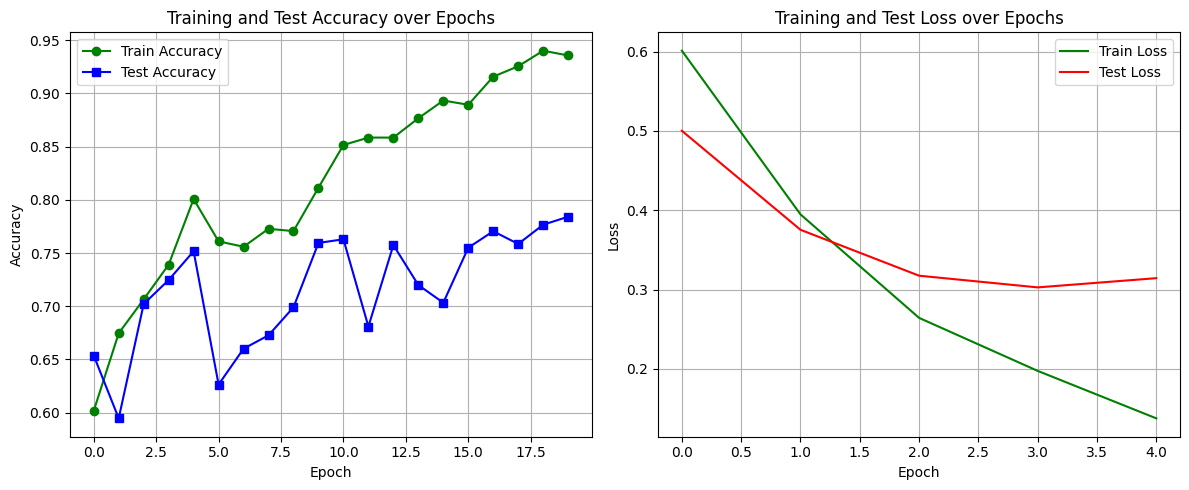

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o', color='green')
plt.plot(test_accuracies, label='Test Accuracy', marker='s', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📌 Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")


📌 Evaluation Metrics:
Accuracy : 0.7842
Precision: 0.7698
Recall   : 0.8108
F1 Score : 0.7898
AUC      : 0.8424


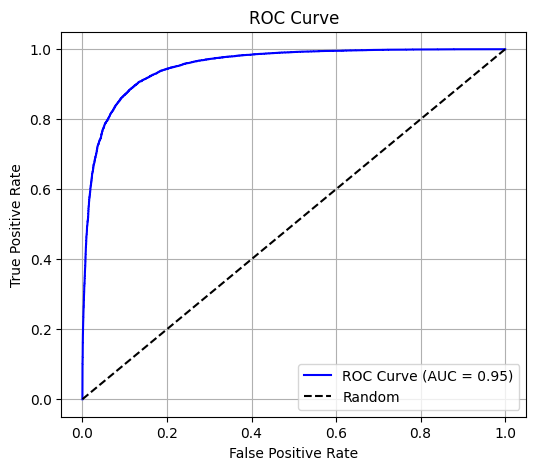

In [ ]:
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## LSTM Model

LSTM menggunakan 3 gerbang: input, forget, dan output gate untuk mengatasi masalah long-term dependency.

### Rumus LSTM:

**Forget gate:**
$$
f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
$$

**Input gate:**
$$
i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
$$

**Cell state:**
$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

**Output gate:**
$$
o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \\
h_t = o_t \cdot \tanh(C_t)
$$

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.lstm1 = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm4 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.lstm5 = nn.LSTM(hidden_dim, hidden_dim//2, batch_first=True)

        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(hidden_dim//2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x = x[:, -1, :]  # ambil output timestep terakhir
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [ ]:
lstm_model = LSTMModel(vocab_size=num_words).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [ ]:
train_losses_lstm, test_losses_lstm = [], []
train_accuracies_lstm, test_accuracies_lstm = [], []

epochs = 15
for epoch in range(epochs):
    lstm_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(inputs).squeeze()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (outputs > 0.5).int()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses_lstm.append(running_loss / len(train_loader))
    train_accuracies_lstm.append(correct / total)

    # Validation
    lstm_model.eval()
    val_loss, correct_val, total_val = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            preds = (outputs > 0.5).int()
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    test_losses_lstm.append(val_loss / len(test_loader))
    test_accuracies_lstm.append(correct_val / total_val)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses_lstm[-1]:.4f} | Val Loss: {test_losses_lstm[-1]:.4f} | "
          f"Train Acc: {train_accuracies_lstm[-1]:.4f} | Val Acc: {test_accuracies_lstm[-1]:.4f}")

Epoch 1 | Train Loss: 0.6898 | Val Loss: 0.6931 | Train Acc: 0.5113 | Val Acc: 0.5012
Epoch 2 | Train Loss: 0.6933 | Val Loss: 0.6931 | Train Acc: 0.5010 | Val Acc: 0.5001
Epoch 3 | Train Loss: 0.6935 | Val Loss: 0.6933 | Train Acc: 0.4945 | Val Acc: 0.5000
Epoch 4 | Train Loss: 0.6934 | Val Loss: 0.6932 | Train Acc: 0.4947 | Val Acc: 0.5000
Epoch 5 | Train Loss: 0.6932 | Val Loss: 0.6933 | Train Acc: 0.4996 | Val Acc: 0.5000
Epoch 6 | Train Loss: 0.6931 | Val Loss: 0.6933 | Train Acc: 0.5055 | Val Acc: 0.5000
Epoch 7 | Train Loss: 0.6932 | Val Loss: 0.6935 | Train Acc: 0.5018 | Val Acc: 0.5000
Epoch 8 | Train Loss: 0.6932 | Val Loss: 0.6933 | Train Acc: 0.4960 | Val Acc: 0.5000
Epoch 9 | Train Loss: 0.6930 | Val Loss: 0.6937 | Train Acc: 0.5008 | Val Acc: 0.5000
Epoch 10 | Train Loss: 0.6931 | Val Loss: 0.6936 | Train Acc: 0.5024 | Val Acc: 0.5000
Epoch 11 | Train Loss: 0.6931 | Val Loss: 0.6937 | Train Acc: 0.4932 | Val Acc: 0.5000
Epoch 12 | Train Loss: 0.6931 | Val Loss: 0.6931 | T

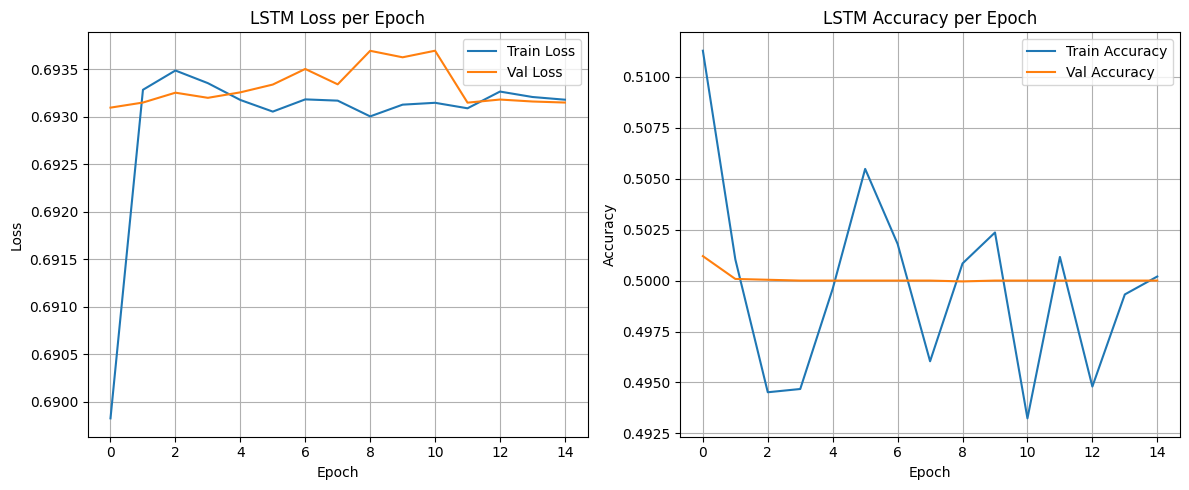

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_lstm, label='Train Loss')
plt.plot(test_losses_lstm, label='Val Loss')
plt.title('LSTM Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_lstm, label='Train Accuracy')
plt.plot(test_accuracies_lstm, label='Val Accuracy')
plt.title('LSTM Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


📊 LSTM Evaluation Metrics:
Accuracy : 0.5000
Precision: 0.5000
Recall   : 1.0000
F1 Score : 0.6667
AUC      : 0.5306


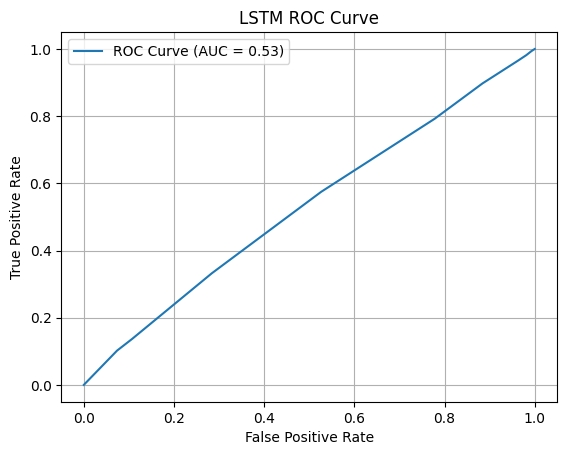

In [ ]:
lstm_model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = lstm_model(inputs).squeeze()
        y_pred_prob.extend(outputs.cpu().detach().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().tolist())
        y_true_all.extend(labels.cpu().tolist())

acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📊 LSTM Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.grid()
plt.legend()
plt.show()

## GRU Model

GRU (Gated Recurrent Unit)

GRU adalah penyederhanaan dari LSTM dengan 2 gate: reset dan update.

### Rumus GRU:

**Update gate:**
$$
z_t = \sigma(W_z \cdot [h_{t-1}, x_t])
$$

**Reset gate:**
$$
r_t = \sigma(W_r \cdot [h_{t-1}, x_t])
$$

**Candidate activation:**
$$
\tilde{h}_t = \tanh(W \cdot [r_t * h_{t-1}, x_t])
$$

**Final hidden state:**
$$
h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t
$$

In [ ]:
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, vocab_size=40000, embed_size=128, hidden_size=128, num_layers=3, dropout=0.3):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers=num_layers,
                          batch_first=True, dropout=dropout, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        x = gru_out[:, -1, :]  # Ambil output dari timestep terakhir
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.out(x)
        return self.sigmoid(x).squeeze()


In [ ]:
gru_model = GRUModel().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

train_losses, test_losses = [], []
train_accs, test_accs = [], []
epochs = 5

for epoch in range(epochs):
    gru_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float()
        optimizer.zero_grad()
        outputs = gru_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = (outputs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    # Evaluation
    gru_model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = gru_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (outputs > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += labels.size(0)
    test_losses.append(val_loss / len(test_loader))
    test_accs.append(correct / total)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Test Acc: {test_accs[-1]:.4f}")

Epoch 1, Train Loss: 0.6013, Test Loss: 0.5003, Train Acc: 0.6718, Test Acc: 0.7630
Epoch 2, Train Loss: 0.3948, Test Loss: 0.3754, Train Acc: 0.8265, Test Acc: 0.8357
Epoch 3, Train Loss: 0.2643, Test Loss: 0.3175, Train Acc: 0.8926, Test Acc: 0.8645
Epoch 4, Train Loss: 0.1974, Test Loss: 0.3027, Train Acc: 0.9236, Test Acc: 0.8781
Epoch 5, Train Loss: 0.1375, Test Loss: 0.3143, Train Acc: 0.9498, Test Acc: 0.8851


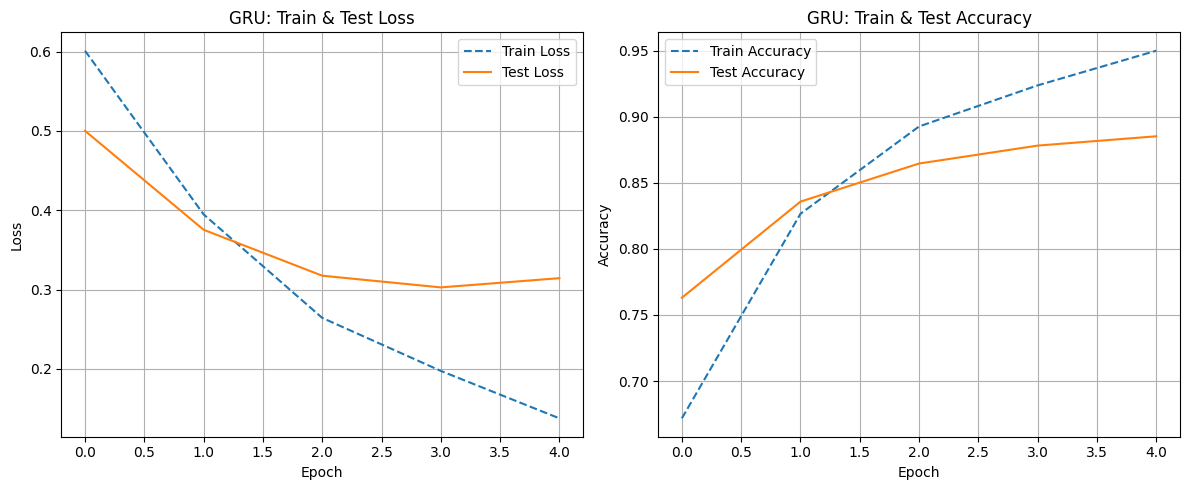

In [ ]:
plt.figure(figsize=(12,5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linestyle='--')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU: Train & Test Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy', linestyle='--')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('GRU: Train & Test Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

gru_model.eval()
y_pred_prob, y_pred_all, y_true_all = [], [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = gru_model(inputs).squeeze()

        y_pred_prob.extend(outputs.cpu().tolist())
        y_pred_all.extend((outputs > 0.5).int().cpu().tolist())
        y_true_all.extend(labels.cpu().tolist())

acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all)
rec = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)
auc = roc_auc_score(y_true_all, y_pred_prob)

print("\n📊 GRU Evaluation Metrics:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")



📊 GRU Evaluation Metrics:
Accuracy : 0.8851
Precision: 0.8952
Recall   : 0.8723
F1 Score : 0.8836
AUC      : 0.9543


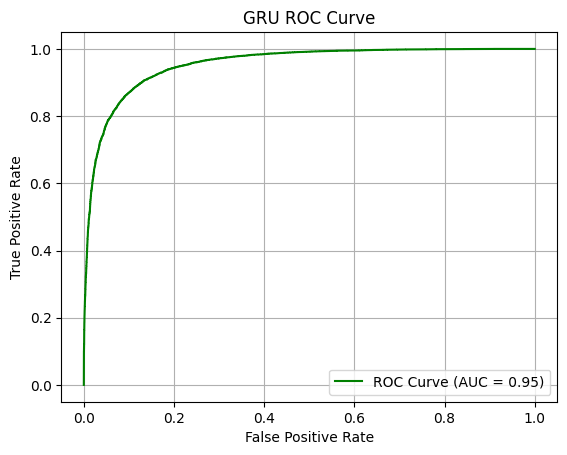

In [ ]:
fpr, tpr, _ = roc_curve(y_true_all, y_pred_prob)

plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GRU ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## Evaluasi Model: Persamaan Matematis dan Penjelasan

### 1. **Binary Cross Entropy Loss (BCELoss)**  
Digunakan sebagai *loss function* pada model klasifikasi biner untuk mengukur selisih antara probabilitas prediksi dan label sebenarnya.

$$
\mathcal{L}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

- Semakin kecil nilai loss, semakin baik model memprediksi label yang benar.
- Digunakan dalam proses *training* untuk memperbarui bobot model melalui backpropagation.

---

### 2. **Accuracy (Akurasi)**  
Mengukur proporsi prediksi yang benar dari seluruh data.

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

- Cocok digunakan saat jumlah data positif dan negatif seimbang.
- Metrik paling umum untuk klasifikasi dasar.

---

### 3. **Precision**  
Mengukur seberapa banyak dari hasil prediksi positif yang benar-benar positif.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- Tinggi ketika model jarang salah mengklasifikasikan negatif sebagai positif.
- Penting untuk kasus seperti deteksi spam.

---

### 4. **Recall (Sensitivity)**  
Mengukur seberapa banyak data positif yang berhasil terdeteksi dengan benar.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- Tinggi ketika model tidak melewatkan banyak data positif.
- Penting untuk kasus seperti diagnosis penyakit.

---

### 5. **F1 Score**  
Merupakan harmonik rata-rata dari Precision dan Recall.

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- Berguna saat terjadi ketidakseimbangan data.
- Memberikan keseimbangan antara Precision dan Recall.

---

### 6. **AUC dan ROC**  
Mengukur kemampuan model dalam membedakan antara kelas positif dan negatif.

$$
\text{AUC} = \int_0^1 TPR(FPR) \, dFPR
$$

Dengan:

$$
TPR = \frac{TP}{TP + FN} \quad , \quad FPR = \frac{FP}{FP + TN}
$$

- ROC Curve menampilkan hubungan antara TPR dan FPR.
- AUC = 1 menunjukkan performa sempurna, AUC = 0.5 berarti tebak-tebakan.
